# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

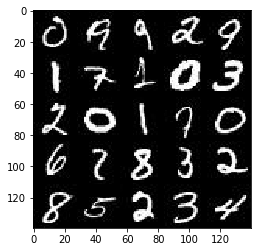

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

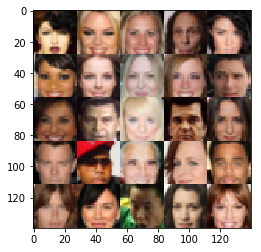

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # alpha for leaky Relu
    alpha =0.2
    keep_prob = 0.5
    
    """ article recommendations:
    Architecture guidelines for stable Deep Convolutional GANs
     Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
    convolutions (generator).
     Use batchnorm in both the generator and the discriminator.
        except generator output layer and the discriminator input layer.
     Remove fully connected hidden layers for deeper architectures.
     Use ReLU activation in generator for all layers except for the output, which uses Tanh.
     Use LeakyReLU activation in the discriminator for all layers."""
    
    """ Tips from review
    Using dropout in discriminator so that it is less prone to learning the data distribution.
    Use custom weight initialization. Xavier init is proposed to work best when working with GANs."""

    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # dropout
        drop = tf.nn.dropout(relu3, keep_prob)

        # Flatten it
        flat = tf.reshape(drop, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # alpha for leaky Relu
    alpha =0.1
        
    """ article recommendations:
    Architecture guidelines for stable Deep Convolutional GANs
     Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
    convolutions (generator).
     Use batchnorm in both the generator and the discriminator.
        except generator output layer and the discriminator input layer.
     Remove fully connected hidden layers for deeper architectures.
     Use ReLU activation in generator for all layers except for the output, which uses Tanh.
     Use LeakyReLU activation in the discriminator for all layers."""
    
    """ Tips from review
    Use leaky_relu.
    Try setting leak for leaky_relu a bit lower. Did you tried 0.1 ?
    Try decreasing the width of layers from 256 -> 64. 
    In context of GANs, a sharp decline in number of filters for Generator helps produce better results."""
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.relu(x1)
        # 7x7 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.relu(x2)
        # 14x14 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 4, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.relu(x3)
        # 14x14 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
        
    return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    """ Tips from review
    Use One Sided Label Smoothing for Discriminator loss, will help it generalize better. 
    If you have two target labels: Real=1 and Fake=0, then for each incoming sample, 
    if it is real, then replace the label with a random number between 0.7 and 1.2, and 
    if it is a fake sample, replace it with 0.0 and 0.3 (for example).
    A simple change like labels = tf.ones_like(d_logits_real) * np.random.uniform(0.7, 1.2) 
    will help with the training process. This is known as label smoothing, typically used with 
    classifiers to improve performance.
    However, only-one-sided label smoothing is recommended to weaken the D and not G."""
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)* np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)* np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt  

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    losses = []
    steps = 0
    print_every=20
    show_every = 100
    n_images=25
    
    # define channel dimension
    if(data_image_mode=="RGB"):
        out_channel_dim = 3
    else:
        out_channel_dim = 1
            
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    print(data_shape)
    print(image_width)
    print(image_height)
    print(image_channels)

    # define generator and discriminator (create)
    inputs_real, inputs_z, learning_rate_tf = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                # normalize images between -1 and +1
                batch_images = batch_images *2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate_tf:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z, learning_rate_tf:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((d_loss, g_loss))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, out_channel_dim, data_image_mode)

    return losses              
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
28
28
1
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 2.2332
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 3.4788
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.5149


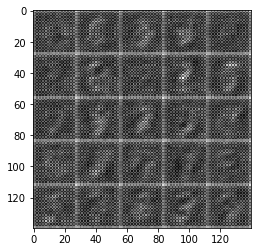

Epoch 1/2... Discriminator Loss: 1.8098... Generator Loss: 4.4629
Epoch 1/2... Discriminator Loss: 1.6056... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 1.1718
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 0.9144


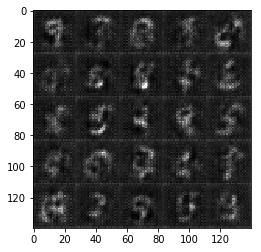

Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.4939
Epoch 1/2... Discriminator Loss: 1.7100... Generator Loss: 3.6442
Epoch 1/2... Discriminator Loss: 2.3653... Generator Loss: 5.1978
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 3.1884
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.8148


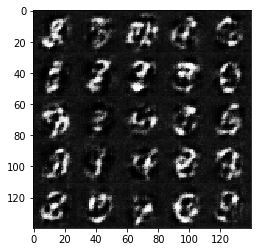

Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 2.1928
Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 1.1388
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 2.9927
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 1.7008


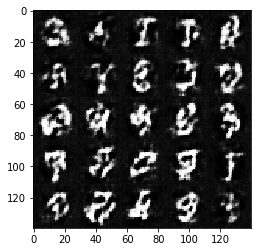

Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.2232
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.7039
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 2.7731
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 2.3377


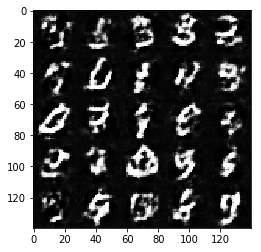

Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 3.5573
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 2.9647
Epoch 1/2... Discriminator Loss: 0.7757... Generator Loss: 2.1043
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.8090


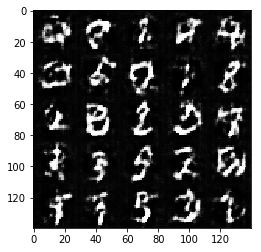

Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.2850
Epoch 1/2... Discriminator Loss: 1.7650... Generator Loss: 3.3184
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 2.5682
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 1.8954
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.3222


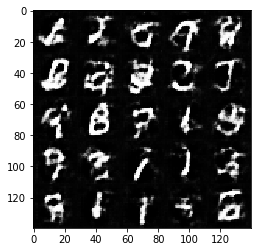

Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.3294
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 2.7296
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 1.2105
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.9556
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 1.0428


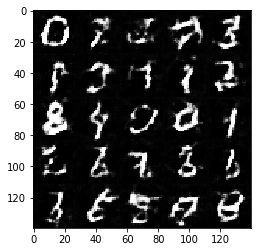

Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 1.2741
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 1.1544
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.3934
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.8583


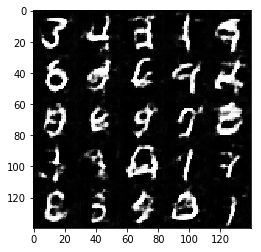

Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 1.4377
Epoch 1/2... Discriminator Loss: 1.0536... Generator Loss: 2.0017
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 1.2360
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 2.3586


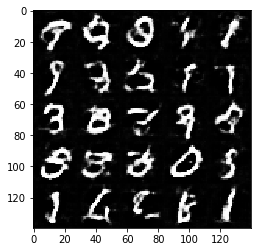

Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.9382... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 1.3255
Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 1.7559
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.7886


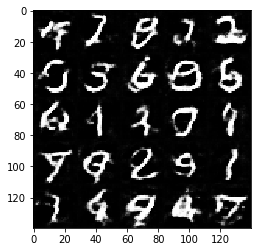

Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 2.0366
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 1.3858
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 1.5315
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.4758


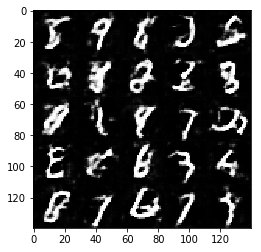

Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 1.0594
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 1.5885
Epoch 1/2... Discriminator Loss: 1.6569... Generator Loss: 0.6369
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 1.4913
Epoch 1/2... Discriminator Loss: 1.6298... Generator Loss: 0.5576


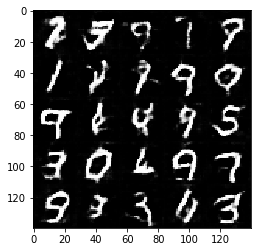

Epoch 1/2... Discriminator Loss: 1.8523... Generator Loss: 0.4153
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 1.2823
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 1.6098
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 1.9160
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 2.1106


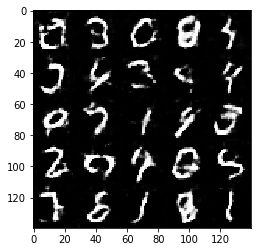

Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.9934
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.4472
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 1.1004


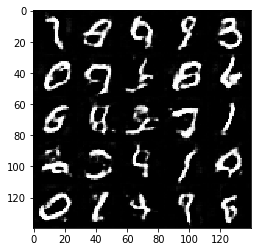

Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.9891
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 0.8179


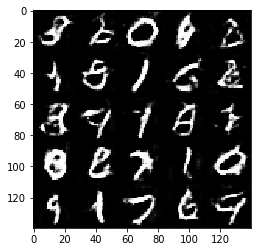

Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.6384
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 2.1851
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 1.1944
Epoch 1/2... Discriminator Loss: 1.9029... Generator Loss: 3.0156


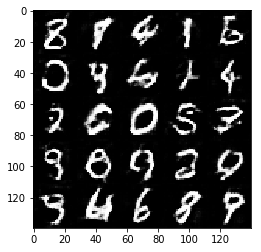

Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 1.7151
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 1.2983
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.5596


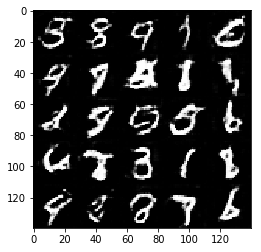

Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 1.0149
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 1.1664
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.8294


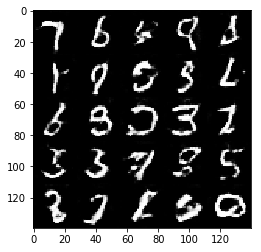

Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 1.1935
Epoch 2/2... Discriminator Loss: 1.0743... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 1.3509
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 1.2636
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 1.5699


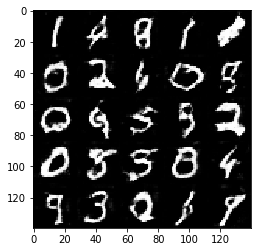

Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 2.3401
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 1.1492
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 1.2742


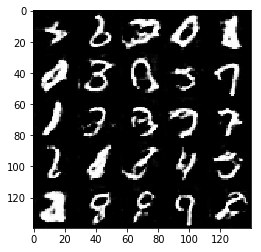

Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 1.7759
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.9883
Epoch 2/2... Discriminator Loss: 2.2036... Generator Loss: 0.2352


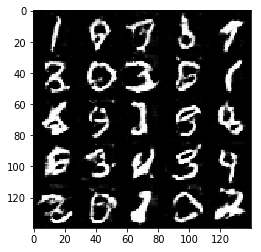

Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.9474
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 1.6120
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.0156


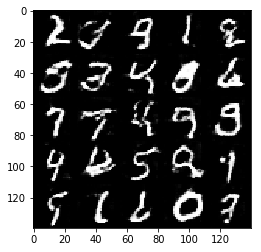

Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 1.3002
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 2.6014


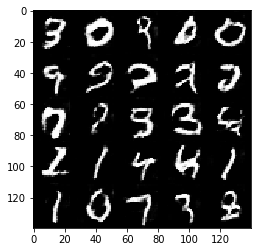

Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.6375... Generator Loss: 2.5194
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 1.1993


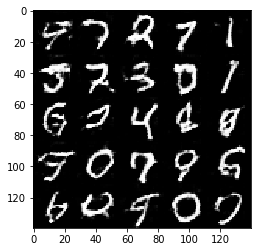

Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.1949
Epoch 2/2... Discriminator Loss: 1.6330... Generator Loss: 0.4301
Epoch 2/2... Discriminator Loss: 0.9573... Generator Loss: 1.3842
Epoch 2/2... Discriminator Loss: 1.0943... Generator Loss: 1.2490
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 1.4115


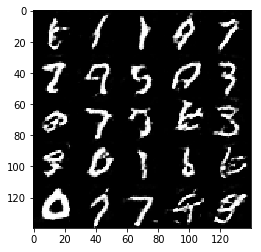

Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 1.7179
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 1.0013
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.8659


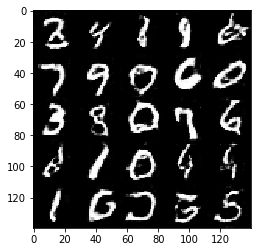

Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.4604
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 2.2411
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 1.0386
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 2.0547
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.4624


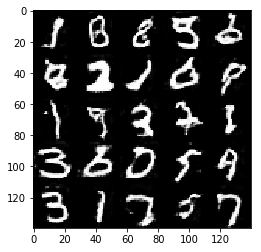

Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 1.4167
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 1.3256
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 1.2435


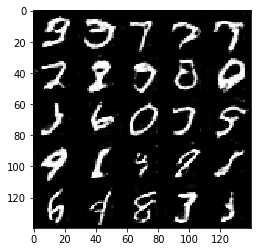

Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 1.6058
Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.5725... Generator Loss: 2.4094
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 1.4439
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.9532


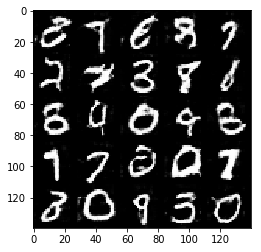

Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 2.0050
Epoch 2/2... Discriminator Loss: 1.7543... Generator Loss: 2.9257
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 1.7065
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.8284


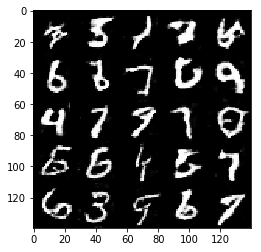

Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 1.8046
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 1.0518
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.1442
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.7364


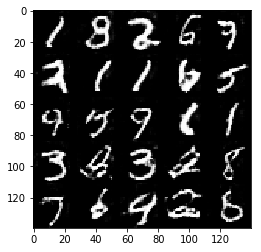

Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.5378
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.2669
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 1.5736
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 2.8398
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 0.9695


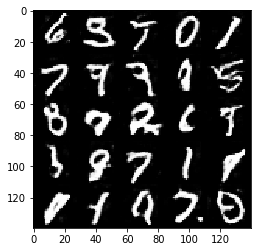

Epoch 2/2... Discriminator Loss: 1.0386... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 1.1559
Epoch 2/2... Discriminator Loss: 1.7874... Generator Loss: 0.5186
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 2.4892


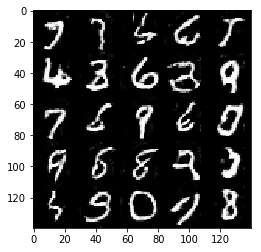

Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 0.9920
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 1.2566
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 1.5589
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.7856


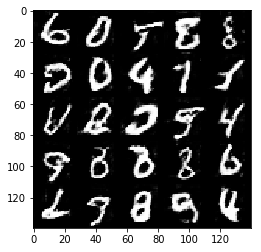

Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 0.9428
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.1949
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.0294
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.6611


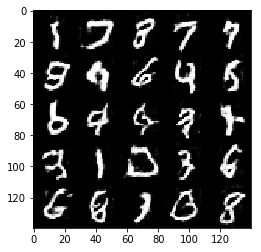

Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 1.1213
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 2.2415
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 1.2822
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 1.2043


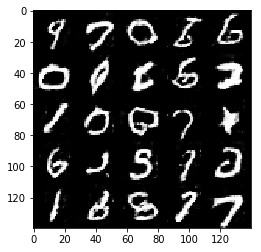

Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 1.0560
Epoch 2/2... Discriminator Loss: 1.9419... Generator Loss: 0.3946


In [46]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
28
28
3
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 3.9864
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.7109
Epoch 1/1... Discriminator Loss: 1.8031... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 1.0927


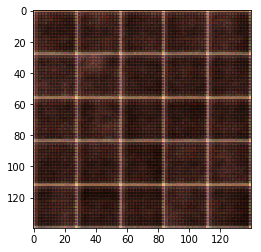

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.4892


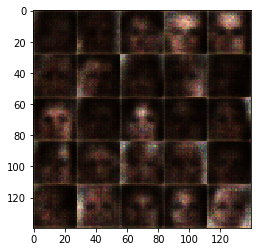

Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.9312
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.9368
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 3.1456
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 2.2021


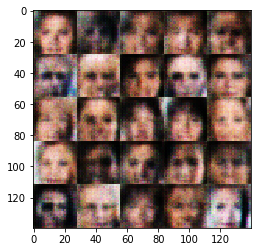

Epoch 1/1... Discriminator Loss: 1.8317... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 2.1959
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.7852... Generator Loss: 0.5216


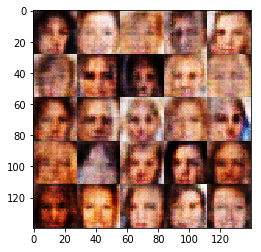

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 1.7136
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.0977


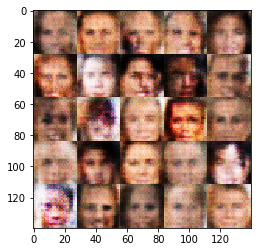

Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.8575
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.7016
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.2993


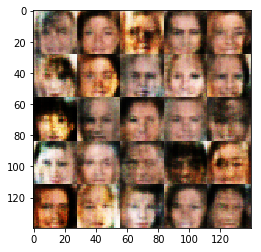

Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.1078


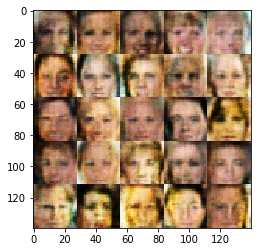

Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.1368


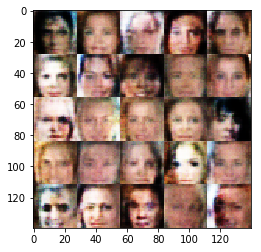

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.9424
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.0983


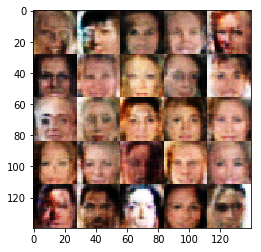

Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 1.4927
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.7799


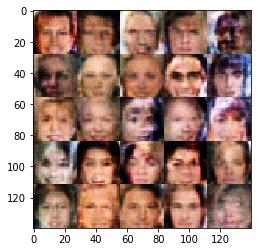

Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.9748
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.9044


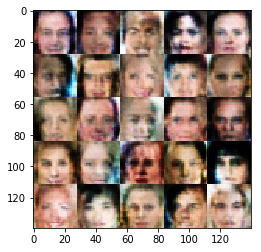

Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 1.8755
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.1620


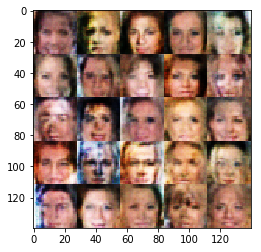

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 2.3437
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.7607


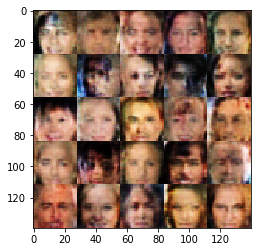

Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.1379


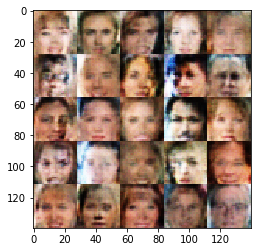

Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 2.0254
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.5710
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.1270


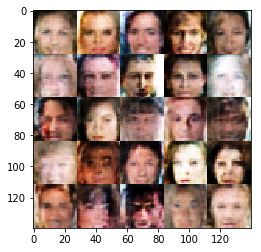

Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.8456... Generator Loss: 0.3863
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8248


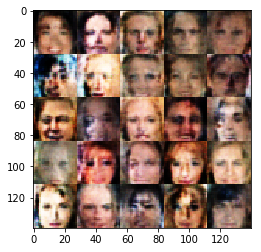

Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.4619
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 2.2746
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 2.0612


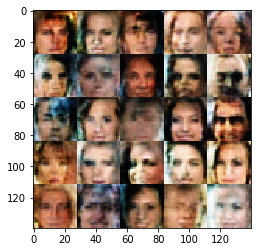

Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 3.3468
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.8290
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.3162


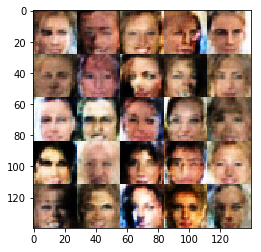

Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.6746
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 3.1271
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 3.2281
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 2.3177
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 2.3473


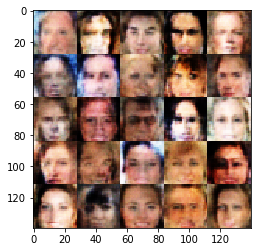

Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 2.8303
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 3.0030
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 3.1263
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 4.3205
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 2.9679


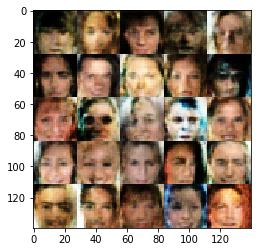

Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 3.8673
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 4.1449
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 3.4374
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 3.8756
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 3.1504


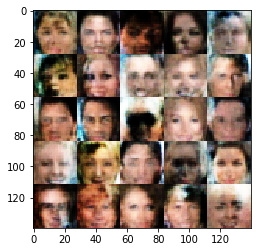

Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 3.5838
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 2.4424
Epoch 1/1... Discriminator Loss: 0.7070... Generator Loss: 1.9943
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.4620
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 5.4424


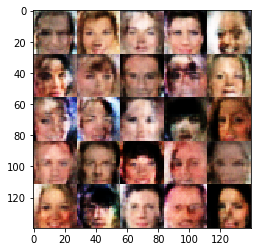

Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 3.0805
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 3.4645
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 3.8711
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 3.1663


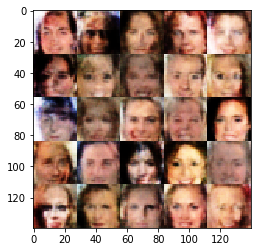

Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 3.3832
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 1.6069
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 2.9546
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6224


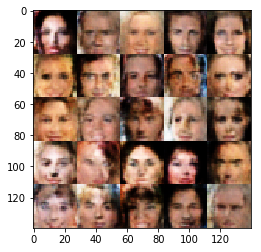

Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 2.5862
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.7300
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.8862
Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 1.8852
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.9900


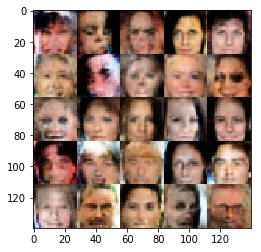

Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 2.3218
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 2.8162
Epoch 1/1... Discriminator Loss: 2.1839... Generator Loss: 2.6259
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 2.2034


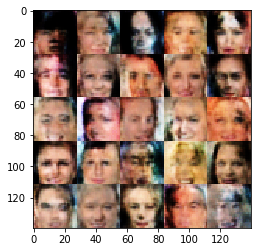

Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 3.4090
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 3.2090
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.0731


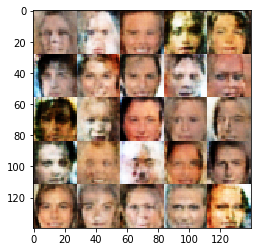

Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.8023
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 2.7179
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 2.3031
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.9666
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.4228


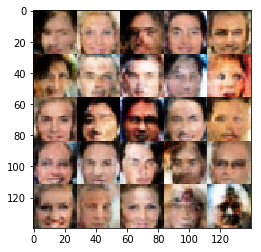

Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 2.3228
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 2.0735
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 2.1005


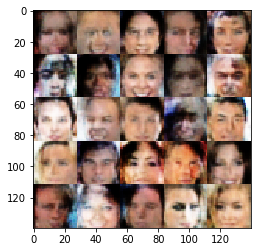

Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 3.9902
Epoch 1/1... Discriminator Loss: 2.2158... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.8957
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 3.1477


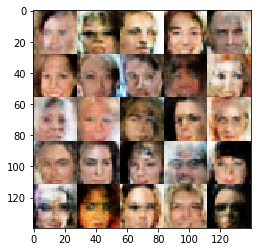

Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 3.0102
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 2.8392
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6653


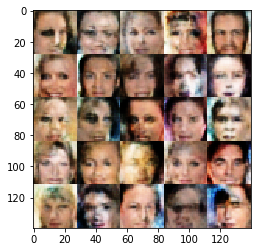

Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 2.0935
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 2.7580
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.8804
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 2.6750
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 2.5301


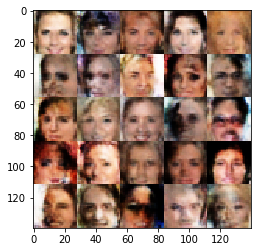

Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 3.2097
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.9052... Generator Loss: 3.2277
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 2.6787


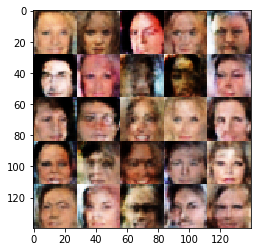

Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 2.2605
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 2.7056
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 3.4826
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 2.1723
Epoch 1/1... Discriminator Loss: 1.7775... Generator Loss: 3.0274


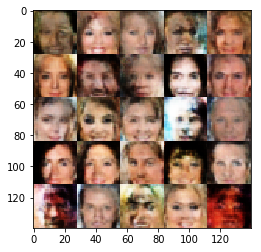

Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 2.5694
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.8466... Generator Loss: 2.7474


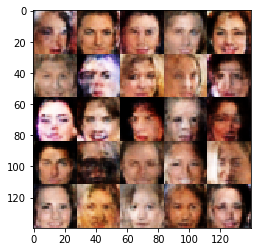

Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 2.4688
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 3.5381
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 2.4776
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.2526


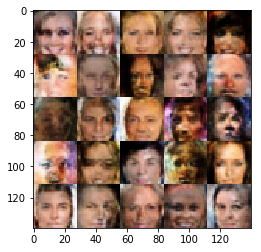

Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 2.2909
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.3869
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 3.3599
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.0122


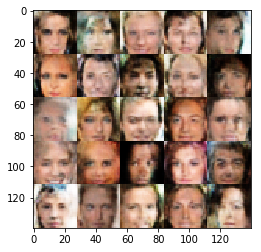

Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 2.1934
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.9511


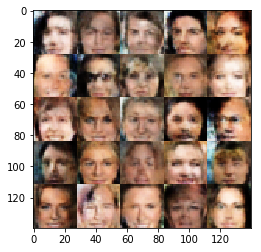

Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.7348
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.7708
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 2.1400
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 2.0803


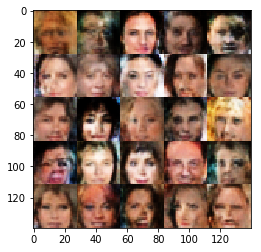

Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 2.1533
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 2.4516
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 2.2758
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 2.3953


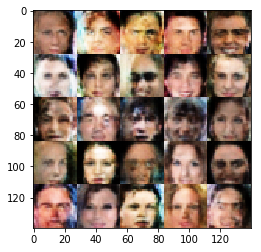

Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.5296
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 2.4885


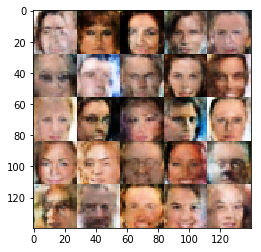

Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.8246
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 1.7356... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.7364


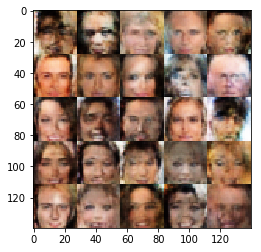

Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.5902
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 2.5891
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.3843
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.1494


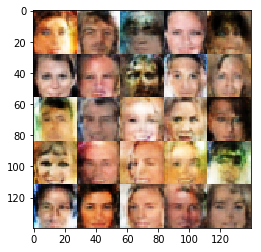

Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.5101
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.9287
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 3.2808
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 2.0272
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 2.1094


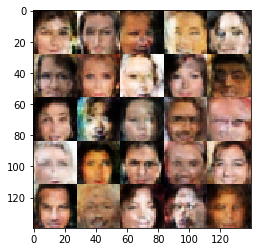

Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 2.3127
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 2.8942
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.7556
Epoch 1/1... Discriminator Loss: 1.8202... Generator Loss: 3.5153


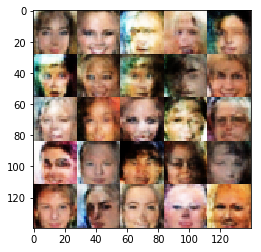

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 2.3816
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 2.3840... Generator Loss: 3.4865
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.7782


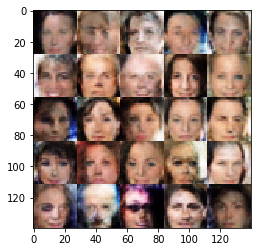

Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.5820
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 2.1658... Generator Loss: 0.3196
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.1099


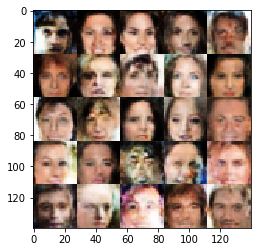

Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 2.0310
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 2.0919
Epoch 1/1... Discriminator Loss: 2.8876... Generator Loss: 0.1509
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.2539


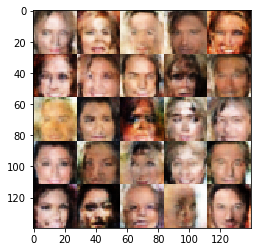

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.8467
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 2.0017
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 2.2706
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6554


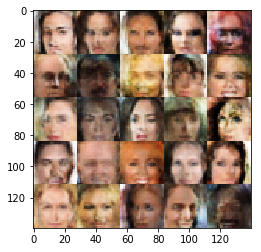

Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.6600
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 2.7877
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.6850


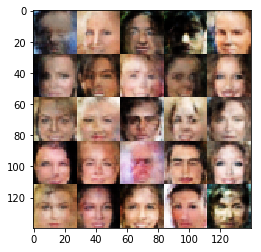

Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 2.2223


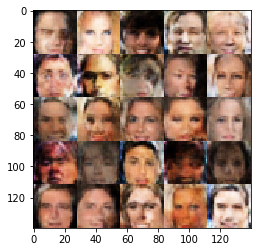

Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 2.1878
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 2.6121
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.3810


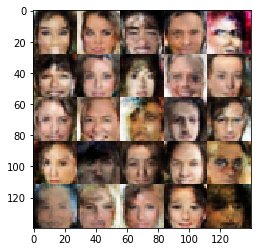

Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.6034
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.6251
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.3244


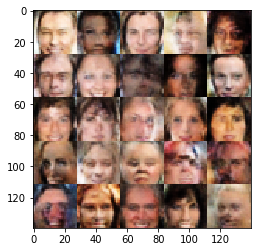

Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.3203


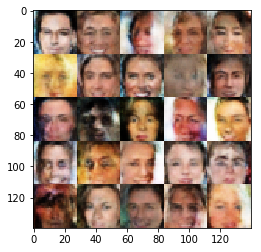

Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 1.6336
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.2835
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.3440


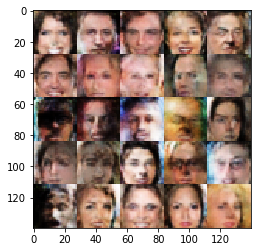

Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.5379
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.9530


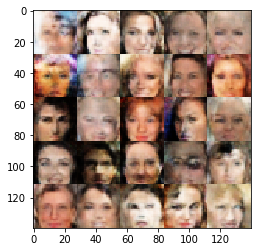

Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.4125
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.5498
Epoch 1/1... Discriminator Loss: 1.6499... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.3355


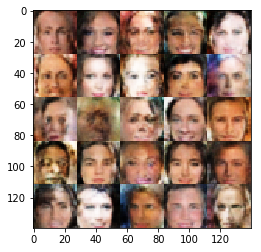

Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.8663
Epoch 1/1... Discriminator Loss: 2.2744... Generator Loss: 0.3341
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 2.1230
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 2.1805
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.8456


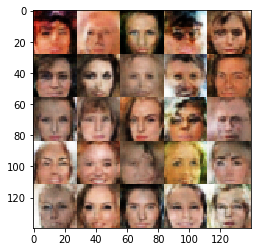

Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 2.2607
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 2.5383
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 1.6688
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.4388


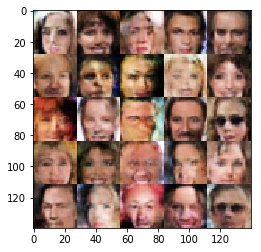

Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 2.0186... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.9164
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.4385


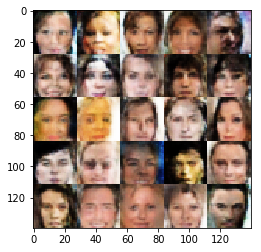

Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.8091


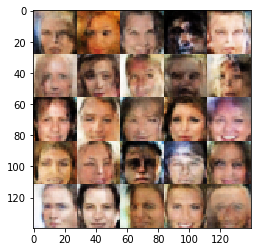

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.5733


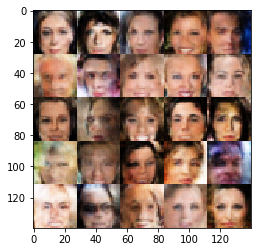

Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.8963
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 2.3204
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.0049


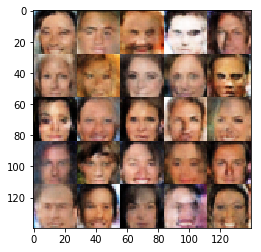

Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 2.0693


In [47]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.